## Multi output model

### Setup

In [1]:
import pandas as pd
import numpy as np
import pretty_midi
# import fluidsynth
# from IPython import display
from IPython.display import Image, Audio
import glob
import collections
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
filenames = glob.glob('../raw_data/mozart_sonatas/mps - K*')
print('Number of files:', len(filenames))
print('first file:', filenames[0])

Number of files: 57
first file: ../raw_data/mozart_sonatas/mps - K311-I.csv


**create pieces df (each row is one piece)**

In [3]:
pieces_df = pd.read_csv('../raw_data/mozart_sonatas/mps - pieces.csv')
pieces_df.head()

,name,key,title,time_sig,tempo marking,bpm,pickup_bar,pickup_length
0,K545-I,c major,NaN,common,allegro,4=132,0,0
1,K545-II,g major,NaN,3/4,andante,4=60,0,0
2,K545-III,c major,Rondo,2/4,allegretto grazioso,4=104,1,4
3,K283-I,g major,NaN,3/4,allegro,4=138,1,4
4,K283-II,c major,NaN,common,andante,4=58,0,0


### Normalize pitches to C major / A minor

**create key converter dictionaries**

In [4]:
# key: # of half steps to add to get to c major / a minor
maj_key_converter_dict = {'a major': 3, 'bb major': 2, 'c major': 0, 'd major': -2, 'eb major': -3, 'f major': -5, 'g major': 5}
min_key_converter_dict = {'a minor': 0, 'c minor': -3, 'f minor': 4}

In [5]:
def normalize_pitches(x, piece_key_type, piece_key):
    if x > 0:
        if piece_key_type == 'major':
            x += maj_key_converter_dict[piece_key]
        else:
            x += min_key_converter_dict[piece_key]
    return x

### Create duration (in seconds) column

In [6]:
bpm_beat_types = set([bpm.split('=')[0] for bpm in pieces_df.bpm.value_counts().index])
bpm_beat_types

{'2', '2d', '4', '4d', '8'}

In [7]:
# bpm note value: amount to multiply bpm by to convert bpm to quarter notes
bpm_converter_dict = {'2': 2, '2d': 3, '4': 1, '4d': 1.5, '8': 0.5}

In [8]:
# duration: amount to multiply spb (seconds per beat) by to get duration in seconds
beat_dict = {
    '1': 4, 
    '2': 2, 
    '4': 1, 
    '8': 0.5,
    '16': 0.25,
    '32': 0.125,
    '64': 0.0625
}

In [9]:
def duration_to_seconds(x, piece_spb):
    if type(x) != 'str':
        x = str(x)
    if x[-2:] == 'dd':
        s = piece_spb * beat_dict[x[:-2]] * 1.75
    elif x[-1] == 'd':
        s = piece_spb * beat_dict[x[:-1]] * 1.5
    else:
        s = piece_spb * beat_dict[x]
    return s

### preprocess all dfs

In [12]:
def process_df(filename):
    
    # extract the K number
    k_num = filename.split(' - ')[1].split('.csv')[0].strip(' ')
    
    # create df
    df = pd.read_csv(filename)  # make df
    
    # normalize pitch
    df['pitch'] = df.note_name.apply(lambda x: pretty_midi.note_name_to_number(x) if x != 'r' else 0)  
    piece_key = pieces_df[pieces_df['name'] == k_num]['key'].values[0].strip(' ')
    piece_key_type = piece_key.split(' ')[1].strip(' ')
    df['pitch_norm'] = df.pitch.apply(normalize_pitches, args=(piece_key_type, piece_key))
    
    # get duration in seconds
    piece_bpm = pieces_df[pieces_df['name'] == k_num]['bpm'].values[0].split('=')
    piece_bpm_norm = int(bpm_converter_dict[piece_bpm[0]] * int(piece_bpm[1]))
    piece_spb = 60 / piece_bpm_norm
    df['dur(s)'] = df.duration.apply(duration_to_seconds, args=(piece_spb,))
    
    return df

In [13]:
all_csv_dfs = []
for file in filenames:
    all_csv_dfs.append(process_df(file))

In [14]:
all_csv_dfs[0].head()

,note_name,duration,measure,beat,subdiv,harm,from_root,NCT,BI2,CI,trill,dynamic,pitch,pitch_norm,dur(s)
0,d5,4,1,1,1,I,1,0,0,0,0,f,74,72,0.454545
1,r,4,1,2,1,0,0,0,0,0,0,f,0,0,0.454545
2,g5,16,1,3,1,I,4,1,0,0,0,f,79,77,0.113636
3,f#5,16,1,3,2,I,3,0,0,0,0,f,78,76,0.113636
4,e5,16,1,3,3,I,2,1,0,0,0,f,76,74,0.113636


### Multi-output model (2 targets - pitch and duration)

In [17]:
# make columns of each pitch-duration pair transposed to 12 keys

for df in all_csv_dfs:
    for i in range(-6, 6):
        pitch_duration = []
        for ind, val in df.iterrows():
            if val.note_name == 'r':
                pitch_duration.append(str(0) + '-' + str(val.duration))
            else:
                pitch_duration.append(str(int(val.pitch_norm + i)) + '-' + str(val.duration))
        df[f'pitch_dur{i}'] = pitch_duration

In [18]:
all_csv_dfs[0].head(3)

,note_name,duration,measure,beat,subdiv,harm,from_root,NCT,BI2,CI,...,pitch_dur-4,pitch_dur-3,pitch_dur-2,pitch_dur-1,pitch_dur0,pitch_dur1,pitch_dur2,pitch_dur3,pitch_dur4,pitch_dur5
0,d5,8d,0,3,1,I6,3,0,0,0,...,72-8d,73-8d,74-8d,75-8d,76-8d,77-8d,78-8d,79-8d,80-8d,81-8d
1,eb5,16,0,3,4,I6,4,1,0,0,...,73-16,74-16,75-16,76-16,77-16,78-16,79-16,80-16,81-16,82-16
2,c5,8,1,1,1,I6,2,1,0,0,...,70-8,71-8,72-8,73-8,74-8,75-8,76-8,77-8,78-8,79-8


In [19]:
# Create mapping of all pitch_dur columns

corpus = []
for df in all_csv_dfs:
    for i in range(-6,6):
        pitch_dur = list(df[f'pitch_dur{i}'])
        corpus = corpus + pitch_dur        

In [20]:
pitch_corpus = [val.split('-')[0] for val in corpus]
duration_corpus = [val.split('-')[1] for val in corpus]

In [21]:
pitch_count_num = collections.Counter(pitch_corpus)
duration_count_num = collections.Counter(duration_corpus)

print("Total notes in dataset:", len(pitch_corpus))
print("Total unique pitches in corpus:", len(pitch_count_num))
print("Total unique durations in corpus:", len(duration_count_num))

Total notes in dataset: 16368
Total unique pitches in corpus: 45
Total unique durations in corpus: 13


In [22]:
# Exploring the notes dictionary
Notes = list(pitch_count_num.keys())
Recurrence = list(pitch_count_num.values())

# Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 363.73333333333335
Most frequent note in Corpus appeared: 871 times
Least frequent note in Corpus appeared: 1 time


In [23]:
# Storing all the unique characters present in the corpus to buid a mapping dict.
pitch_symb = sorted(list(set(pitch_corpus)))
duration_symb = sorted(list(set(duration_corpus)))

# Dictionary to convert duration into length in 64th notes
len_in_64th_notes = {'64': 1, '32': 2, '32d': 3, '16': 4, '16d': 6, '8': 8, '8d': 12, 
                     '8dd': 14, '4': 16, '4d': 24, '2': 32, '2d': 48, '1': 64}
reverse_len_in_64th_notes = {v: k for k, v in len_in_64th_notes.items()}

L_pitch_corpus = len(pitch_corpus)  # length of corpus
L_duration_corpus = len(duration_corpus)
L_pitch_symb = len(pitch_symb)  # length of total unique characters
L_duration_symb = len(duration_symb)

# Building dictionary to access the vocabulary from indices and vice versa
pitch_mapping = dict((int(c), i) for i, c in enumerate(pitch_symb))
pitch_reverse_mapping = dict((i, int(c)) for i, c in enumerate(pitch_symb))
duration_mapping = dict((len_in_64th_notes[c], i) for i, c in enumerate(duration_symb))
duration_reverse_mapping = dict((i, len_in_64th_notes[c]) for i, c in enumerate(duration_symb))

print("Total number of characters:", L_pitch_corpus)
print("Number of unique characters:", L_pitch_symb)

Total number of characters: 16368
Number of unique characters: 45


In [24]:
test_df = all_csv_dfs[0]

In [25]:
test_list = list(test_df['pitch_dur0'])

In [26]:
length = 6
for i in range(0, len(test_list) - length, 1):
  feature = test_list[i:i + length]
  feature_split = [val.split('-') for val in feature]
  feature_mapped = [[val[0], len_in_64th_notes[val[1]]] for val in feature_split]
  feature_full_map = [
                        [
                          pitch_mapping[int(val[0])], 
                          duration_mapping[int(val[1])]
                        ] 
                      for val in feature_mapped
                      ]
  print(feature_full_map)
  # print([duration_mapping[val[1]] for val in feature_split])
  # print([val.split('-')[1] for val in feature])


[[28, 11], [29, 1], [26, 10], [24, 10], [24, 7], [24, 7]]
[[29, 1], [26, 10], [24, 10], [24, 7], [24, 7], [23, 7]]
[[26, 10], [24, 10], [24, 7], [24, 7], [23, 7], [0, 7]]
[[24, 10], [24, 7], [24, 7], [23, 7], [0, 7], [29, 11]]
[[24, 7], [24, 7], [23, 7], [0, 7], [29, 11], [31, 1]]
[[24, 7], [23, 7], [0, 7], [29, 11], [31, 1], [28, 10]]
[[23, 7], [0, 7], [29, 11], [31, 1], [28, 10], [26, 10]]
[[0, 7], [29, 11], [31, 1], [28, 10], [26, 10], [26, 7]]
[[29, 11], [31, 1], [28, 10], [26, 10], [26, 7], [26, 7]]
[[31, 1], [28, 10], [26, 10], [26, 7], [26, 7], [24, 7]]


In [27]:
# Splitting the corpus in equal length of strings and output target
length = 6
features = []
target_pitch = []
target_duration = []
for df in all_csv_dfs:
    # make embedded list of pitch_dur columns
    pitch_dur_columns = []
    for i in range(-6,6):
        pitch_dur_columns.append(list(df[f'pitch_dur{i}']))
    # add slices to features and pitch / duration to targets
    L_df = len(df)
    for column in pitch_dur_columns:    
        for i in range(0, L_df - length, 1):
          feature = column[i:i + length]
          feature_split = [val.split('-') for val in feature]
          feature_mapped = [[val[0], len_in_64th_notes[val[1]]] for val in feature_split]
          feature_full_map = [[pitch_mapping[int(val[0])], duration_mapping[int(val[1])]] for val in feature_mapped]
          features.append(feature_full_map)

          target = column[i + length]
          target_split = target.split('-')
          target_pitch.append(pitch_mapping[int(target_split[0])])
          target_duration.append(duration_mapping[len_in_64th_notes[target_split[1]]])
    
L_datapoints = len(target_pitch)
print("Total number of sequences in the corpus:", L_datapoints)

Total number of sequences in the corpus: 12264


In [28]:
target_duration[25]

10

In [29]:
# reshape X
X = (np.reshape(features, (L_datapoints, length, 2)))
# normalize X
X_norm = np.zeros(X.shape[0]*X.shape[1]*X.shape[2]).reshape(X.shape)
X_norm[:, :, 0] = X[:, :, 0] / float(L_pitch_symb)
X_norm[:, :, 1] = X[:, :, 1] / float(L_duration_symb)

# one hot encode the output variable
#y = to_categorical(targets)

**getting class weights for target**

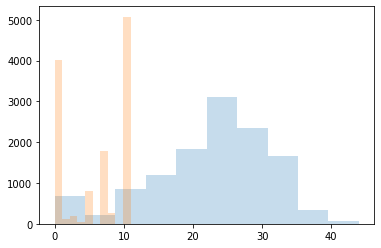

In [30]:
plt.hist(target_pitch, alpha=0.25)
plt.hist(target_duration, alpha=0.25);

In [31]:
pitch_counts = np.unique(np.array(target_pitch), return_counts=True)
duration_counts = np.unique(np.array(target_duration), return_counts=True)

In [32]:
pitch_class_weights_simple = {key:val for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights_simple = {key:val for key, val in zip(duration_counts[0], duration_counts[1])}
pitch_mean = np.mean(list(pitch_class_weights_simple.values()))
duration_mean = np.mean(list(duration_class_weights_simple.values()))
pitch_class_weights = {key:(1 / val) * pitch_mean for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights = {key:(1 / val) * duration_mean for key, val in zip(duration_counts[0], duration_counts[1])}

In [33]:
pcw = pitch_class_weights
dcw = duration_class_weights

pcw_keys = list(pitch_class_weights)
dcw_keys = list(duration_class_weights)
for i in range(max(pcw_keys)):
  if i not in pcw_keys:
    pcw[i] = 0

for i in range(max(dcw_keys)):
  if i not in dcw_keys:
    dcw[i] = 0

**Prepare y data**

In [34]:
y_pitch = np.array(target_pitch).reshape(-1,1)
y_duration = np.array(target_duration).reshape(-1,1)
target_all = np.hstack((y_pitch, y_duration))

In [35]:
y = {"pitch_output": y_pitch, "duration_output": y_duration}

### Code Alec sent me 
# y_train = {"pitch_output": y_train_pitch, "duration_output": y_train_duration}
# y_val = {"pitch_output": y_val_pitch, "duration_output": y_val_duration}

# history = model.fit(
    # x = X_train,
# 	  y = y_train,
# 	  validation_data=(X_test,y_test)
# )

In [36]:
y['duration_output']

array([[ 7],
       [ 7],
       [11],
       ...,
       [ 5],
       [10],
       [10]])

**multi-output model**

In [37]:
from numpy.core.fromnumeric import shape
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


# loss = CategoricalCrossentropy()

opt = RMSprop(learning_rate=0.001)

def initialize_model():
    
    input_layer = Input(shape=X_norm.shape[1:], name='input_layer')
    first_LSTM = LSTM(512, name='first_LSTM', activation='tanh')(input_layer)
    first_dropout = Dropout(0.1, name='first_dropout')(first_LSTM)
    first_dense = Dense(256, name='first_dense', activation='tanh')(first_dropout)
    second_dropout = Dropout(0.1, name='second_dropout')(first_dense)

    pitch_output = Dense(len(pcw), name='pitch_output', activation='softmax')(second_dropout)
    duration_output = Dense(len(dcw), name='duration_output', activation='softmax')(second_dropout)

    model = Model(inputs=input_layer, outputs=[pitch_output, duration_output])

    losses = {
        "pitch_output": "sparse_categorical_crossentropy",
	      "duration_output": "sparse_categorical_crossentropy",
        }

    loss_weights = {
        "pitch_output": 0.5, 
        "duration_output": 0.5
    }

    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights,metrics=["accuracy"])

    return model

    # model.compile(optimizer=opt,
    #           loss={'pitch_output': loss, 'duration_output': loss})
  

    # model.add(LSTM(512, activation='tanh', input_shape=X.shape[1:], return_sequences=True))
    # model.add(Dropout(0.1))
    # model.add(LSTM(256, activation='tanh'))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.1))
    # model.add(Dense(y.shape[1], activation='softmax'))
    
    # model.compile(loss=loss, optimizer=opt)
    
    # return model

In [38]:
model = initialize_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 6, 2)]       0           []                               
                                                                                                  
 first_LSTM (LSTM)              (None, 512)          1054720     ['input_layer[0][0]']            
                                                                                                  
 first_dropout (Dropout)        (None, 512)          0           ['first_LSTM[0][0]']             
                                                                                                  
 first_dense (Dense)            (None, 256)          131328      ['first_dropout[0][0]']          
                                                                                              

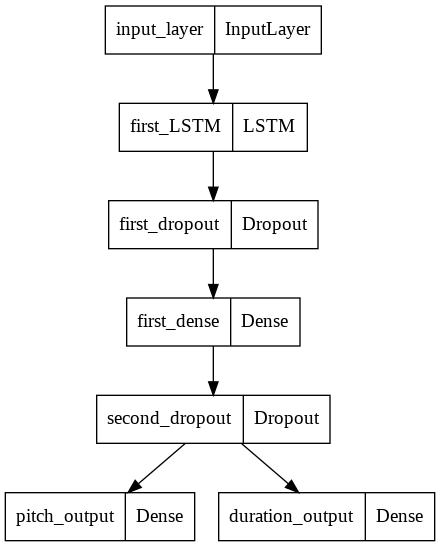

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [40]:
es = EarlyStopping(patience=20, restore_best_weights=True)

class_weight = {'pitch_output': pcw, 'duration_output': dcw}

history = model.fit(X, y, validation_split=0.2, batch_size=32, epochs=120, verbose=1, callbacks=[es])

Epoch 1/120
307/307 [==============================] - 18s 24ms/step - loss: 2.1272 - pitch_output_loss: 2.9981 - duration_output_loss: 1.2564 - pitch_output_accuracy: 0.0879 - duration_output_accuracy: 0.6025 - val_loss: 2.2940 - val_pitch_output_loss: 2.8637 - val_duration_output_loss: 1.7242 - val_pitch_output_accuracy: 0.1072 - val_duration_output_accuracy: 0.5520
Epoch 2/120
307/307 [==============================] - 6s 19ms/step - loss: 1.9162 - pitch_output_loss: 2.7158 - duration_output_loss: 1.1166 - pitch_output_accuracy: 0.1170 - duration_output_accuracy: 0.6352 - val_loss: 2.1940 - val_pitch_output_loss: 2.7700 - val_duration_output_loss: 1.6181 - val_pitch_output_accuracy: 0.0995 - val_duration_output_accuracy: 0.5809
Epoch 3/120
307/307 [==============================] - 5s 18ms/step - loss: 1.8106 - pitch_output_loss: 2.6152 - duration_output_loss: 1.0061 - pitch_output_accuracy: 0.1392 - duration_output_accuracy: 0.6621 - val_loss: 2.3091 - val_pitch_output_loss: 2.8233

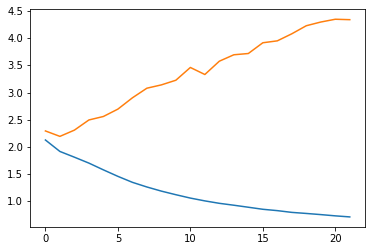

In [41]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss']);

**exploring model.predict**

In [42]:
sample = X_norm[0].reshape(1, length, 2)
pitch_pred, duration_pred = model.predict(sample, verbose=1)

1/1 [==============================] - 1s 745ms/step


In [43]:
predictions = model.predict(sample)
predictions

[array([[1.00564705e-02, 3.16338241e-02, 1.86122190e-02, 2.79555432e-02,
         1.36865983e-02, 1.11679301e-01, 1.60095498e-01, 2.02464908e-01,
         1.13002904e-01, 7.63538033e-02, 4.60127443e-02, 3.01749241e-02,
         2.39703432e-02, 9.78953112e-03, 3.76298395e-03, 4.44492418e-03,
         1.81645586e-03, 9.42101993e-04, 2.39463887e-04, 4.38864168e-04,
         3.67219967e-04, 2.00512048e-04, 2.66097923e-04, 9.51135953e-05,
         2.08301091e-04, 1.81075346e-04, 4.09677974e-04, 4.02708451e-04,
         5.44612529e-04, 5.64365473e-04, 8.12744722e-04, 1.44220260e-03,
         4.00166446e-03, 2.69838772e-03, 6.65243203e-03, 4.93588997e-03,
         1.12986015e-02, 1.42213572e-02, 1.69674959e-02, 1.48012135e-02,
         1.74547900e-02, 3.14680510e-03, 4.37675277e-03, 6.58881711e-03,
         2.27665092e-04]], dtype=float32),
 array([[0.07096191, 0.36071858, 0.00169617, 0.02561335, 0.02379934,
         0.07090067, 0.00215109, 0.25203192, 0.02768971, 0.00212978,
         0.11804

In [44]:
duration_pred.shape

(1, 12)

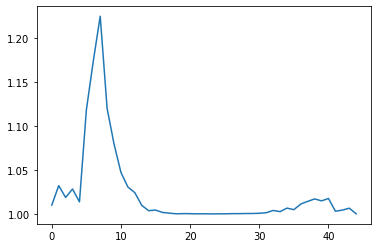

In [45]:
plt.plot(list(range(len(pitch_pred[0]))), np.exp(pitch_pred[0]));

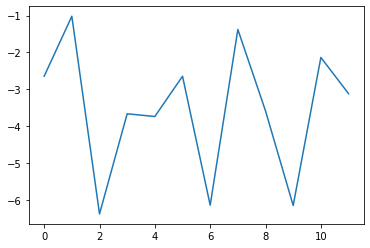

In [46]:
plt.plot(list(range(len(duration_pred[0]))), np.log(duration_pred[0]));

In [47]:
exp_pitch_preds = np.exp(pitch_pred[0])
pitch_pred = exp_pitch_preds / np.sum(exp_pitch_preds)
print(np.sum(pitch_pred))
pitch_pred

1.0


array([0.02193246, 0.02241085, 0.02212092, 0.02232857, 0.02201222,
       0.02427849, 0.02548288, 0.02658578, 0.02431064, 0.02343581,
       0.02273542, 0.02237818, 0.02223976, 0.02192661, 0.02179486,
       0.02180973, 0.02175248, 0.02173347, 0.02171821, 0.02172254,
       0.02172098, 0.02171736, 0.02171878, 0.02171507, 0.02171753,
       0.02171694, 0.0217219 , 0.02172175, 0.02172484, 0.02172526,
       0.02173066, 0.02174434, 0.02180007, 0.02177167, 0.02185793,
       0.02182044, 0.02195972, 0.022024  , 0.02208456, 0.02203677,
       0.02209533, 0.02178144, 0.02180824, 0.02185654, 0.02171795],
      dtype=float32)

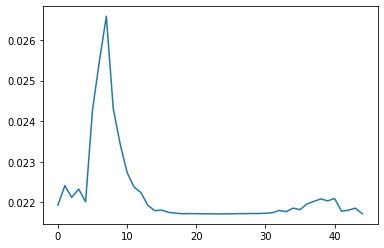

In [48]:
plt.plot(list(range(len(pitch_pred))), pitch_pred)

In [49]:
pitch_index = np.argmax(pitch_pred)
pitch_index

7

In [50]:
duration_pred

array([[0.07096191, 0.36071858, 0.00169617, 0.02561335, 0.02379934,
        0.07090067, 0.00215109, 0.25203192, 0.02768971, 0.00212978,
        0.11804592, 0.0442616 ]], dtype=float32)

In [51]:
pitch_pred_top_3_ind = np.argpartition(pitch_pred, -3)[-3:]
dur_pred_top_2_ind = np.argpartition(duration_pred, -2)[0][-2:]
print(pitch_pred_top_3_ind)
print(dur_pred_top_2_ind)

[8 6 7]
[7 1]


In [52]:
np.random.choice(dur_pred_top_2_ind)

1

In [53]:
three_notes = [[pitch, np.random.choice(dur_pred_top_2_ind)] for pitch in pitch_pred_top_3_ind]
three_notes

[[8, 1], [6, 7], [7, 7]]

In [54]:
[[pitch_reverse_mapping[pitch], reverse_len_in_64th_notes[duration_reverse_mapping[duration]]] for pitch, duration in three_notes]

[[56, '16'], [54, '4'], [55, '4']]

In [55]:
pitch_pred_top_3_ind / float(L_pitch_symb)

array([0.17777778, 0.13333333, 0.15555556])

**generating three notes**

In [56]:
# return predictions from sample
sample = X_norm[0].reshape(1, length, 2)
pitch_pred, duration_pred = model.predict(sample)

# get log of predictions
pitch_pred = np.log(pitch_pred[0]) / 1.0  # diversity?
duration_pred = np.log(duration_pred[0])

# un-log predictions (not sure why we logged them...)
exp_pitch_preds = np.exp(pitch_pred)
exp_duration_preds = np.exp(duration_pred)

# make odds of all predictions = 1.0
pitch_pred = exp_pitch_preds / np.sum(exp_pitch_preds)
duration_pred = exp_duration_preds / np.sum(exp_duration_preds)

# get top 3 pitch predictions and top 2 duration predictions
pitch_index_top_3 = np.argpartition(pitch_pred, -3)[-3:]
dur_index_top_2 = np.argpartition(duration_pred, -2)[-2:]

# return three notes as [pitch, duration] pairs
three_notes = [[pitch, np.random.choice(dur_index_top_2)] for pitch in pitch_index_top_3]
three_notes_mapped = [[pitch_reverse_mapping[pitch], reverse_len_in_64th_notes[duration_reverse_mapping[duration]]] for pitch, duration in three_notes]

three_notes_mapped

### for model.prediction input
# pitch_index_N = pitch_index_top_3 / float(L_pitch_symb)
# duration_index_N = duration_index_top_3 / float(L_duration_symb)

[[56, '4'], [54, '4'], [55, '16']]

**TODO create loop that asks user to choose one of three notes each time**

In [61]:
note_count = 10
Music = ""
notes_generated = []
for i in range(note_count):
    sample = X_norm[0].reshape(1, length, 2)
    pitch_pred, duration_pred = model.predict(sample, verbose=1)

    pitch_pred = np.log(pitch_pred[0]) / 1.0  # diversity?
    duration_pred = np.log(duration_pred[0])

    exp_pitch_preds = np.exp(pitch_pred)
    exp_duration_preds = np.exp(duration_pred)

    pitch_pred = exp_pitch_preds / np.sum(exp_pitch_preds)
    duration_pred = exp_duration_preds / np.sum(exp_duration_preds)

    pitch_index_top_3 = np.argpartition(pitch_pred, -3)[0][-3:]
    dur_index_top_3 = np.argpartition(duration_pred, -3)[0][-2:]

    ### for model.prediction input
    # pitch_index_N = pitch_index_top_3 / float(L_pitch_symb)
    # duration_index_N = duration_index_top_3 / float(L_duration_symb)

    three_notes = [[pitch, np.random.choice(dur_pred_top_3_ind)] for pitch in pitch_index_top_3]
    three_notes_mapped = [[pitch_reverse_mapping[pitch], reverse_len_in_64th_notes[duration_reverse_mapping[duration]]] for pitch, duration in three_notes]

    # notes_generated.append([pitch_index, duration_index])

    # Music = [reverse_mapping[char] for char in notes_generated]
    # seed = np.insert(sample[0], len(sample[0]), index_N)
    # sample = sample[1:]

1/1 [==============================] - 0s 16ms/step


IndexError: ignored

### Create midi file

In [ ]:
def notes_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start)
        end = float(prev_start + note['dur(s)'])
        if note['note_name'] == 'r':
            start += float(note['dur(s)'])
            prev_start = start
        else:
            note = pretty_midi.Note(
                velocity=velocity,
                pitch=note.pitch_norm,
#                 pitch=int(pretty_midi.note_name_to_number(note['note_name'])),
                start=start,
                end=end
            )
            instrument.notes.append(note)
            prev_start = end
            
    pm.instruments.append(instrument)
    return pm

In [ ]:
instrument_name = 'Acoustic Guitar (nylon)'

all_midis = []
for df in all_csv_dfs:
    pm = notes_to_midi(df, instrument_name)
    all_midis.append(pm)

In [ ]:
instrument = all_midis[0].instruments[0]
instrument.notes

### Playback the midi

In [ ]:
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    return display.Audio(waveform, rate=_SAMPLING_RATE)

In [ ]:
# instrument_name = 'Electric Piano 1'
instrument_name = 'Acoustic Guitar (nylon)'
out_file = 'example.midi'

example_pm = notes_to_midi(all_csv_dfs[10], instrument_name)

In [ ]:
#display_audio(example_pm)

### Create dataframe from midi

In [ ]:
filenames[45]

In [ ]:
instrument = example_pm.instruments[0]
instrument.notes

In [ ]:
def midi_to_notes(midi: pretty_midi.PrettyMIDI()) -> pd.DataFrame:
#     pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = midi.instruments[0]
    notes = collections.defaultdict(list)
    
    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start-prev_start)
        notes['duration'].append(end - start)
        prev_start = start
        
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
all_midi_dfs = []

for midi in all_midis:
    midi_df = midi_to_notes(midi)
    all_midi_dfs.append(midi_df)

In [ ]:
all_midi_dfs[45].head()

In [ ]:
max_pitch_list = []
min_pitch_list = []
pitch_list = []
for midi in all_midi_dfs:
    max_pitch_list.append(midi.pitch.max())
    min_pitch_list.append(midi.pitch.min())
    for pitch in midi.pitch:
        if pitch not in pitch_list:
            pitch_list.append(pitch)

In [ ]:
pitch_list.sort()
print(f"highest note: {max(max_pitch_list)} ({pretty_midi.note_number_to_name(max(max_pitch_list))})")
print(f"lowest note:, {min(min_pitch_list)} ({pretty_midi.note_number_to_name(min(min_pitch_list))})")
print('number of different notes:', len(pitch_list))